In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interpn
from astropy.io import fits
import healpy as hp
import sys
from scipy.special import erf

In [2]:
# Constants & Unit conversion

# Joule to erg
JtoERG = 1.e7

# mega jansky, [erg s^-1 cm-2 Hz^-1]
MJy = 1.e-17 

# Planck constant, [J Hz^-1] 
h =  6.62607015e-34

# Boltzmann constant [J K^-1]
kb = 1.380649e-23

# Speed of light [m s^-1]
c =  299792458. 

# CMB Black body temperature [K]
T_CMB = 2.726

# Convert from FWHM to STD
FWHM_TO_STD = np.sqrt(8.*np.log(2))

In [3]:
def BB(nu, T):
    '''
    Returns the black-body emission at frequency nu and temperature T

            Parameters:
                    nu (float): frequency in Hz
                    T (float): temperature in K

            Returns:
                    em (float): the black-body emission at frequency nu and temperature T [W m^-2 sr^-1 Hz^-1]
    '''
    return 2.*h*np.power(nu, 3)*np.power(c, -2)*np.power(np.exp(h*nu/(kb*T))-1., -1)

def BB_KCMB(nu, T):
    '''
    Returns the black-body emission at frequency nu and temperature T in K_CMB units

            Parameters:
                    nu (float): frequency in Hz
                    T (float): temperature in K

            Returns:
                    em (float): the black-body emission at frequency nu and temperature T in K_CMB units [K]
    '''
    x = h * nu / (kb * T)
    return x * T * np.power(np.exp(x)-1, -1)


def deltaIvSZ (nu, T=T_CMB):
    x = h * nu / (kb * T)
    exp_x = np.exp(x)
    I0 = 2 * (kb * T)**3 / (h * c) **2   
    return I0 * x**4 * exp_x / (exp_x-1)**2 * (x * (exp_x+1)/(exp_x-1) - 4)


def jSZ (nu, T=T_CMB):
    x = h * nu / (kb * T)
    exp_x = np.exp(x)
    
    return (x * (exp_x+1)/(exp_x-1) - 4)


Text(0, 0.5, '$I_\\nu \\, [K_{CMB}]$')

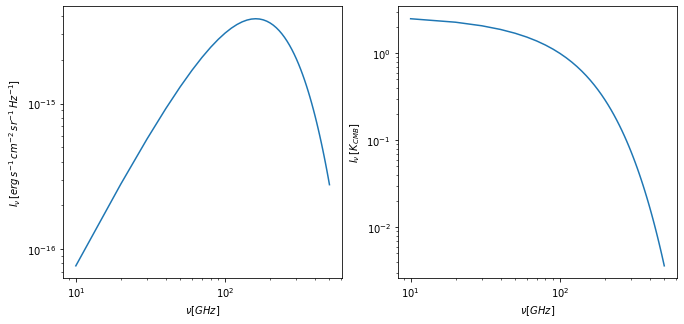

In [4]:
figure, ax = plt.subplots(1, 2, figsize=(11,5))

nu = np.linspace(10, 500)
ax[0].loglog(nu, BB(nu*1.e9, T_CMB)*1.e3)
ax[0].set_xlabel(r"$\nu [GHz]$")
ax[0].set_ylabel(r"$I_\nu \, [erg \, s^{-1} \, cm^{-2} \, sr^{-1} \, Hz ^{-1}]$")

ax[1].loglog(nu, BB_KCMB(nu*1.e9, T_CMB))
ax[1].set_xlabel(r"$\nu [GHz]$")
ax[1].set_ylabel(r"$I_\nu \, [K_{CMB}]$")



Text(0, 0.5, '$I_{\\nu} \\, [MJy \\, sr^{-1}]$')

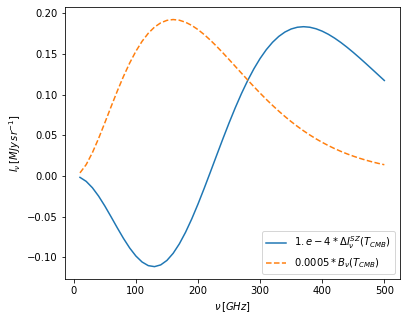

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(nu, 1.e-4*deltaIvSZ(nu*1.e9)*1.e20, label=r"$1.e-4*\Delta I^{SZ}_{\nu}(T_{CMB})$")
ax.plot(nu, 0.0005*BB(nu*1.e9, T_CMB)*1.e20, ls="--", label=r"$0.0005*B_{\nu}(T_{CMB})$")
ax.legend(loc="best")
ax.set_xlabel(r"$\nu \, [GHz]$")
ax.set_ylabel(r"$I_{\nu} \, [MJy \, sr^{-1}]$")

In [6]:
# Planck-related units and conversions

# Frequencies of HFI channels [GHz]
HFI_nu = np.array([100., 143., 217., 353., 545., 857.]) # 100., 143., 217., 353., 545., 857.]) #GHZ

# Beam aperture of HFI channels [arcsec^2] CHECK!
HFI_beam = {100 : 9.66/FWHM_TO_STD, 143 : 7.27/FWHM_TO_STD, 217 : 5.01/FWHM_TO_STD, 353 : 4.86/FWHM_TO_STD, 545 : 4.84/FWHM_TO_STD, 857 : 4.63/FWHM_TO_STD} #arcmin, std

# MJy to K_CMB transformation
HFI_MJY_KCMB = { 100 : 1./238.815, 143 : 1./380.0, 217 : 1./483.82,  353 : 1./296.877, 545 : 1./57.1943, 857 : 1./1.43907}

# YSZ to K_CMB transformation
HFI_YSZ_KCMB = { 100 : -4.031, 143 : -2.785, 217 : -0.187,  353 : 6.205, 545 : 14.445, 857 : 26.335}

# Black body emission 
BB_CMB = {100 : BB(100.*1.e9, T_CMB)/MJy*HFI_MJY_KCMB[100],
          143 : BB(143.*1.e9, T_CMB)/MJy*HFI_MJY_KCMB[143],
          217 : BB(217.*1.e9, T_CMB)/MJy*HFI_MJY_KCMB[217],
          353 : BB(353.*1.e9, T_CMB)/MJy*HFI_MJY_KCMB[353],
          545 : BB(545.*1.e9, T_CMB)/MJy*HFI_MJY_KCMB[545],
          857 : BB(857.*1.e9, T_CMB)/MJy*HFI_MJY_KCMB[857]}

# II column in HFI maps
HFI_nu_to_idx = {100:4, 143:4, 217:4, 353:4, 545:2, 857:2}

# SZ spectral distribution in ysz units
HFI_jsz = {100 : jSZ(100.*1.e9, T_CMB)/HFI_YSZ_KCMB[100],
           143 : jSZ(143.*1.e9, T_CMB)/HFI_YSZ_KCMB[143],
           217 : jSZ(217.*1.e9, T_CMB)/HFI_YSZ_KCMB[217],
           353 : jSZ(353.*1.e9, T_CMB)/HFI_YSZ_KCMB[353],
           545 : jSZ(545.*1.e9, T_CMB)/HFI_YSZ_KCMB[545],
           857 : jSZ(857.*1.e9, T_CMB)/HFI_YSZ_KCMB[857]}

In [7]:
def y_sz_profile ( theta1, theta2, y500, theta500, beta=2./3): #check!
    xx = (theta1*theta1+theta2*theta2)*np.power(theta500, -2)
    return y500*np.power(1.+xx, -(3*beta-1)/2)

def HFI_temperature_profile ( theta1, theta2, theta500, jj, beta=2./3):
    xx = (theta1*theta1+theta2*theta2)*np.power(theta500, -2)
    return jj*np.power(1.+xx, -(3.*beta-1.)/2)

In [8]:
def read_maps():
    '''
    Read variance maps for all frequencies
    
    Return dictionary that contains the variance maps in healpix format in ysz units
    '''
    variance_maps = {}
    for nu in HFI_nu.astype(int):
        name = "../input/HFI_SkyMap_%d_2048_R2.02_full.fits"%nu
        variance_maps[nu] = np.power(HFI_YSZ_KCMB[nu], -2)*hp.read_map(name,field=HFI_nu_to_idx[nu])
        if( (nu == 545) or (nu==857) ):
            variance_maps[nu] = np.power(HFI_MJY_KCMB[nu],2)*variance_maps[nu]
    return variance_maps

In [9]:
# Read the maps
variance_maps = read_maps()


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [10]:
def get_TmapSk_theta500_1(nx=100, ratio=10, theta500=1.):

    theta_axis = np.linspace(-ratio*theta500, ratio*theta500, nx) 
    theta_step = theta_axis[1]-theta_axis[0]
    theta1, theta2 = np.meshgrid(theta_axis, theta_axis)

    TmapSk = {}
    for nu in HFI_nu.astype(int):
        Tmap = HFI_temperature_profile(theta1, theta2, theta500, HFI_jsz[nu])
        TmapS = gaussian_filter(Tmap, HFI_beam[nu], mode="nearest")
        TmapSk[nu] = np.fft.fft2(TmapS)#/np.sqrt(TmapS.size))

    freq = np.fft.fftshift(np.fft.fftfreq(TmapSk[HFI_nu[0].astype(int)].size, theta_step))
    deltafreq = freq[1]-freq[0]
    return TmapSk, deltafreq

TmapSk, deltafreq = get_TmapSk_theta500_1(theta500=1.)

In [11]:
def get_sigma (theta500, theta, phi):

    pix = hp.ang2pix(2048, theta, phi)
    integrand = np.zeros(shape=TmapSk[HFI_nu[0].astype(int)].shape)
    for nu in HFI_nu.astype(int):
        integrand += np.dot(TmapSk[nu].T, TmapSk[nu]).real/variance_maps[nu][pix]

    return np.power(np.sum(integrand*deltafreq*deltafreq*theta500**2), -0.5)


In [13]:
from tqdm.notebook import tqdm

npix = hp.nside2npix(256)
err_map = np.zeros(npix)
for i in tqdm(range(npix)):
    theta, phi = hp.pix2ang(256, i)
    pix2048 = hp.ang2pix(256, theta, phi)
    err_map[i] = get_sigma (1., theta, phi)

  0%|          | 0/786432 [00:00<?, ?it/s]

In [14]:
def erf_compl(y500, sigma500, q):
    return 0.5 * (1 + erf((y500 - q * sigma500)/(np.sqrt(2)*sigma500)))

/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:898: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:899: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under("w")
/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:900: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, y

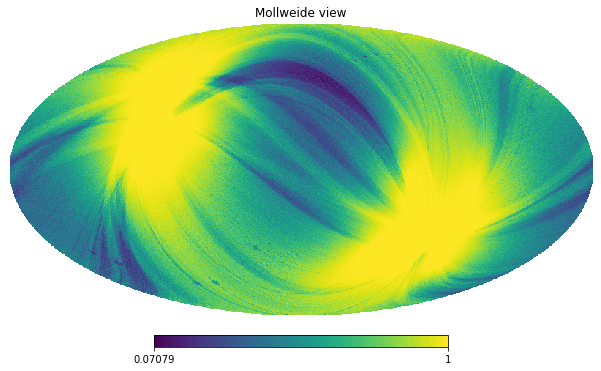

In [15]:
y500 = 1.e-3
theta500 = 6
q = 4.5

hp.mollview(erf_compl(y500, err_map*theta500, q))

In [16]:
hp.write_map("HFI_ysz_visibility_1m3_6.fits", erf_compl(y500, err_map * theta500, q), overwrite=True)

$$ E^{-\beta}(z)\left[\frac{D_{\mathrm{A}}^{2}(z) \bar{Y}_{500}}{10^{-4} \mathrm{Mpc}^{2}}\right]=Y_{*}\left[\frac{h}{0.7}\right]^{-2+\alpha}\left[\frac{(1-b) M_{500}}{6 \times 10^{14} M_{\odot}}\right]^{\alpha} $$

$$
\bar{\theta}_{500}=\theta_{*}\left[\frac{h}{0.7}\right]^{-2 / 3}\left[\frac{(1-b) M_{500}}{3 \times 10^{14} M_{\odot}}\right]^{1 / 3} E^{-2 / 3}(z)\left[\frac{D_{\mathrm{A}}(z)}{500 \mathrm{Mpc}}\right]^{-1}
$$

In [17]:
from scipy.special import erf
import CosmoBolognaLib as cbl

cosmology = cbl.Cosmology(cbl.CosmologicalModel__Planck18_,  "LCDM", False)

sr_to_arcmin_sq = 11818102.860

def Y500_mean(z, cosmology, M500, beta=0.66, Ystar = 10**-0.19, alpha=1.79, b=0): #arcmin**2
    return Ystar * (cosmology.hh()/0.7) ** (-2 + alpha) * (( 1- b ) * M500/6.e14)**alpha * \
           (cosmology.EE(z)**-beta * cosmology.D_A(z)**2/1.e-4)**-1 * sr_to_arcmin_sq

def theta500_mean(z, cosmology, M500, thetastar= 6.997, b=0):
    return thetastar * (cosmology.hh()/0.7)**(-2/3) * (( 1- b ) * M500/3.e14)**(1./3) *\
           cosmology.EE(z)**(-2./3) * (cosmology.D_A(z) / 500) ** (-1)

In [18]:
# Read the data
from astropy.table import Table
union_table = Table().read("../input/HFI_PCCS_SZ-union_R2.08.fits.gz").to_pandas()

In [19]:
# You can play here to perform different selections
final_sample = union_table[(union_table["REDSHIFT"] > 0)]

In [20]:
zmed = final_sample["REDSHIFT"].median()
Mmed = final_sample["MSZ"].median()


In [21]:
y500 = np.array([Y500_mean(zz, cosmology, mm*1.e14, b=0.) for zz, mm in zip(final_sample["REDSHIFT"], final_sample["MSZ"])])


In [22]:
print(zmed)

0.224


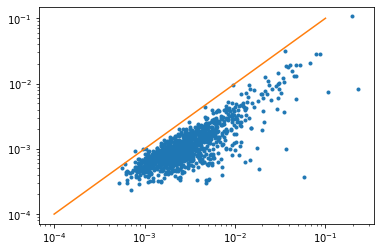

In [23]:
plt.loglog(final_sample["Y5R500"]*1.e-3, y500, ".")
x = np.logspace(-4, -1, 100)
plt.plot(x,x)

/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:898: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:899: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under("w")
/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:900: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, y

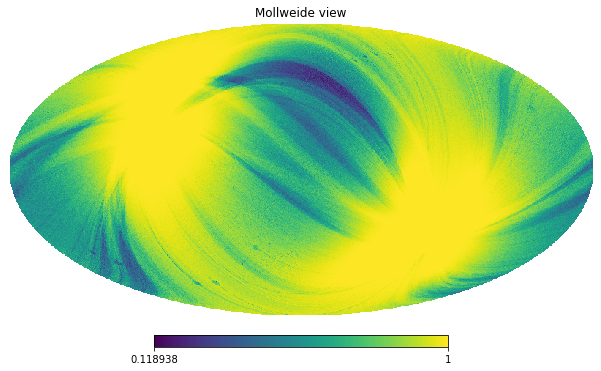

In [24]:
y500 = Y500_mean(zmed.astype(np.float64), cosmology, Mmed*1.e14, b=0.)
theta500 = theta500_mean (zmed.astype(np.float64), cosmology, Mmed*1.e14, b=0.)
q = 4.5

hp.mollview(erf_compl(y500, err_map * theta500, q))

In [25]:
hp.write_map("HFI_ysz_visibility_zmean_mass_mean.fits", erf_compl(y500, err_map * theta500, q), overwrite=True)